In [ ]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution() # needed to fix conversion error, but why?

from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
dataset = datasets.AIFB()
display(HTML(dataset.description))
G, affiliation = dataset.load()

In [3]:
affiliation.dtypes

<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id1instance>    uint8
<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id2instance>    uint8
<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id3instance>    uint8
<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id4instance>    uint8
<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id5instance>    uint8
dtype: object

In [4]:
affiliation


,<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id1instance>,<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id2instance>,<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id3instance>,<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id4instance>,<http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id5instance>
source,,,,,
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id1842instance>,1,0,0,0,0
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id1862instance>,1,0,0,0,0
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id58instance>,0,0,1,0,0
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2042instance>,1,0,0,0,0
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2051instance>,0,0,0,1,0
...,...,...,...,...,...
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id55instance>,0,0,1,0,0
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id11instance>,0,0,1,0,0
<http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id86instance>,0,0,1,0,0


In [5]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 8285, Edges: 29043

 Node types:
  default: [8285]
    Features: float32 vector, length 8285
    Edge types: default-http://swrc.ontoware.org/ontology#abstract->default, default-http://swrc.ontoware.org/ontology#address->default, default-http://swrc.ontoware.org/ontology#author->default, default-http://swrc.ontoware.org/ontology#booktitle->default, default-http://swrc.ontoware.org/ontology#carriedOutBy->default, ... (40 more)

 Edge types:
    default-http://swrc.ontoware.org/ontology#publication->default: [4163]
        Weights: all 1 (default)
        Features: none
    default-http://www.w3.org/1999/02/22-rdf-syntax-ns#type->default: [4124]
        Weights: all 1 (default)
        Features: none
    default-http://swrc.ontoware.org/ontology#author->default: [3986]
        Weights: all 1 (default)
        Features: none
    default-http://swrc.ontoware.org/ontology#isAbout->default: [2477]
        Weights: all 1 (default)
        Features: 

In [6]:
train_targets, test_targets = model_selection.train_test_split(
    affiliation, train_size=0.8, test_size=None
)

print(type(train_targets))
print(type(test_targets))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [7]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_targets.index, targets=train_targets)
test_gen = generator.flow(test_targets.index, targets=test_targets)

print(type(train_gen))
print(type(test_gen))

<class 'stellargraph.mapper.sequences.RelationalFullBatchNodeSequence'>
<class 'stellargraph.mapper.sequences.RelationalFullBatchNodeSequence'>


In [8]:
rgcn = RGCN(
    layer_sizes=[32, 32],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=20,
    dropout=0.5,
)

In [9]:
x_in, x_out = rgcn.in_out_tensors()
#x_in = np.asarray(x_in)
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)


print(type(x_in))
print(type(x_out))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<class 'list'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [10]:
print(datetime.now())
history = model.fit(train_gen, validation_data=test_gen, epochs=20)
print(datetime.now())

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 1.6146 - acc: 0.2676 - val_loss: 1.5727 - val_acc: 0.5833
Epoch 2/20
1/1 [==============================] - 7s 7s/step - loss: 1.5489 - acc: 0.6761 - val_loss: 1.4711 - val_acc: 0.8056
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 1.3793 - acc: 0.8521 - val_loss: 1.2616 - val_acc: 0.8333
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 1.1751 - acc: 0.8873 - val_loss: 0.9729 - val_acc: 0.8333
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 0.8008 - acc: 0.8873 - val_loss: 0.7337 - val_acc: 0.8333
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 0.5953 - acc: 0.9296 - val_loss: 0.5916 - val_acc: 0.8889
Epoch 7/20
1/1 [==============================] - 6s 6s/step - loss: 0.5477 - acc: 0.9225 - val_loss: 0.4981 - val_acc: 0.8889
Epoch 8/20
1/1 [==============================] - 7s 7s/step - loss: 0.3857 - acc: 0.9437 - val_loss: 0.4402 - 

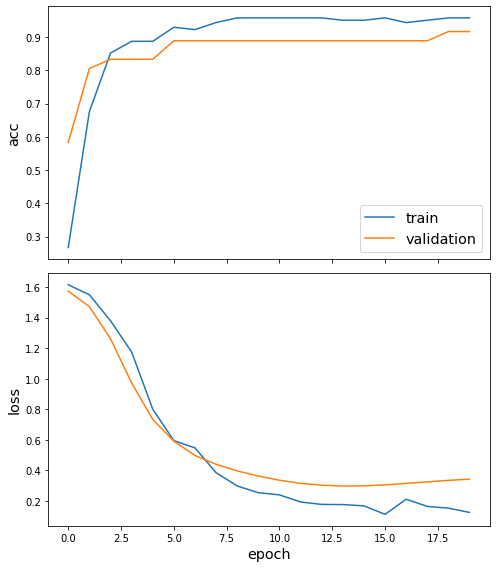

In [11]:
sg.utils.plot_history(history)

In [14]:

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))




Test Set Metrics:
	loss: 0.3436
	acc: 0.9167


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# get embeddings for all people nodes
all_gen = generator.flow(affiliation.index, targets=affiliation)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict(all_gen)

X = emb.squeeze(0)
y = affiliation.idxmax(axis="columns").astype("category")

if X.shape[1] > 2:
    transform = TSNE

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=affiliation.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=affiliation.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

NameError: name 'emb_transformed' is not defined

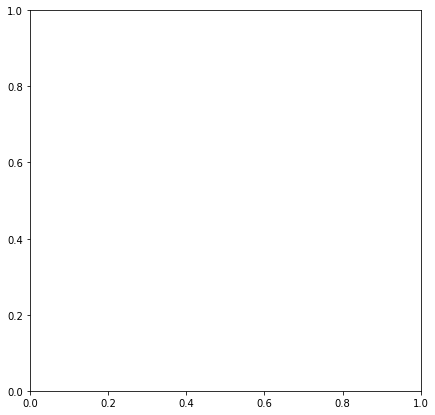

In [15]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of RGCN embeddings for AIFB dataset".format(transform.__name__)
)
plt.show()